In [1]:
!pwd

/Users/jietao/Documents/GitHub/FML_Group_Project


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, feature
from skimage.feature import hog

t_train = pd.read_csv('./t_train_project.csv')
x_train = pd.read_csv('./x_train_project.csv')

print("t_train shape:", t_train.shape)
print("x_train shape:", x_train.shape)

t_train shape: (5999, 1)
x_train shape: (5999, 10000)


In [38]:
# selected_image = x_train.iloc[27].values.reshape(100, 100)

# plt.figure(figsize=(8, 8))
# plt.imshow(selected_image, cmap='gray')

# mean_intensity = np.mean(selected_image)
# std_intensity = np.std(selected_image)

# new_img = np.ones_like(selected_image) * 255 # initialize a new image with all white pixels
# significant_pixels = np.abs(selected_image - mean_intensity) > 2 * std_intensity # any pixels that are more than 2 std dev from the mean (likely the stroke pixels)... array of booleans
# new_img[significant_pixels] = selected_image[significant_pixels] # set the stroke pixels to the original intensity

# bright_pixels = (selected_image > mean_intensity) & significant_pixels
# new_img[bright_pixels] = 255 - selected_image[bright_pixels]

# plt.figure(figsize=(8, 8))
# plt.imshow(new_img, cmap='gray')


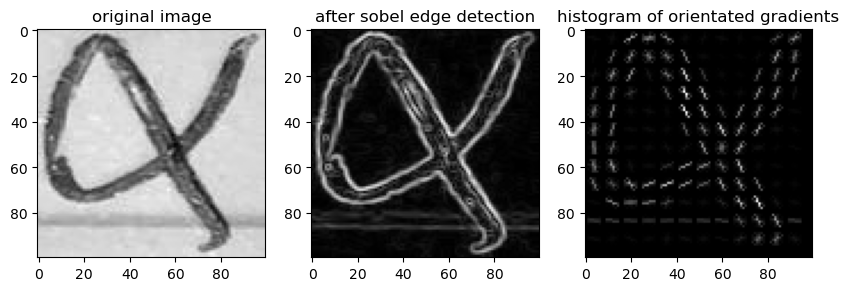

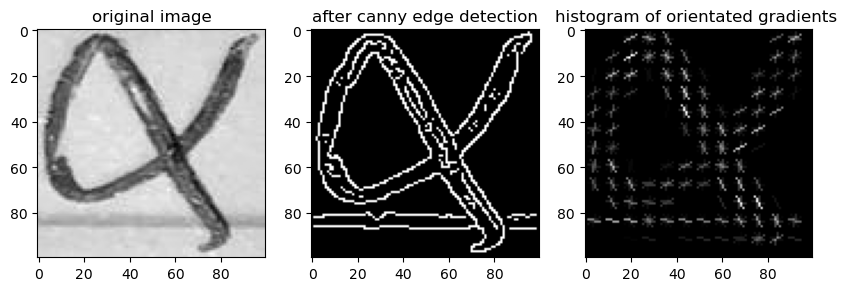

In [127]:
selected_image = x_train.iloc[38].values.reshape(100, 100)


###### TESTING SOBEL EDGE DETECTION

plt.figure(figsize=(10, 8))
plt.subplot(1, 3, 1)
plt.imshow(selected_image, cmap='gray')
plt.title('original image')

sobel_filter = filters.sobel(selected_image)
plt.subplot(1, 3, 2)
plt.imshow(sobel_filter, cmap='gray')
plt.title('after sobel edge detection')

_, hog_image = hog(selected_image, orientations=8, pixels_per_cell=(8, 8), visualize=True)
plt.subplot(1, 3, 3)
plt.imshow(hog_image, cmap='gray')
plt.title('histogram of orientated gradients')

###### NOW TESTING CANNY EDGE DETECTION

plt.figure(figsize=(10, 8))
plt.subplot(1, 3, 1)
plt.imshow(selected_image, cmap='gray')
plt.title('original image')

# all image pixels minus the smallest pixel intensity value and divided by the range of the image
normalized_image = (selected_image - selected_image.min()) / (selected_image.max() - selected_image.min())

canny_edges = feature.canny(normalized_image)
plt.subplot(1, 3, 2)
plt.imshow(canny_edges, cmap='gray')
plt.title('after canny edge detection')

_, hog_image = hog(canny_edges, orientations=8, pixels_per_cell=(8, 8), visualize=True)
plt.subplot(1, 3, 3)
plt.imshow(hog_image, cmap='gray')
plt.title('histogram of orientated gradients ')

plt.show()

In [125]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


X = np.array(x_train).reshape(5999, 100, 100, 1) # the data dimension with dimension "1" needs to be explicitly stated here for the CNN
y = np.array(t_train)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# normalize everything for the CNN and MLP (from 0 to 1)
X_train = X_train / 255
X_val = X_val / 255

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)), # slide a 2x2 pooling filter to reduce overfitting
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Flatten(), # flatten for the input layer of the MLP
    # mlp part
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='softmax') # output layer for the 10 possible classes
])

y_train_one_hot_encoded = np.zeros((y_train.shape[0], 10)) # 2d data tensors w/ each row corresponding to one data sample's one hot encoding for calculating the difference (error) between model output and labels
y_val_one_hot_encoded = np.zeros((y_val.shape[0], 10))

for i in range(len(y_train)):
    y_train_one_hot_encoded[i, y_train[i]] = 1
    
for i in range(len(y_val)):
    y_val_one_hot_encoded[i, y_val[i]] = 1

# print(y_val_one_hot_encoded)

y_train = y_train_one_hot_encoded
y_val = y_val_one_hot_encoded

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=16,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("validation accuracy:", val_accuracy)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 10, 10, 128)      